In [ ]:
# Inisialisasi kebutuhan library
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import seaborn as sns; sns.set()
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist



from google.colab import files

# Tubes Pembelajaran Mesin
Unserpervised Learning , K-Means Clustering.
Oleh I Gde Bagus Janardana Abasan ( 1301190061 ) Kelas IF-43-06. Tugas ini adalah mengelompokkan pelanggan berdasarkan data pelanggan tanpa memperhatikan label kelas apakah pelanggan tertarik untuk membeli kendaraan baru atau tidak.

# DATA EXPLORATION
---


## ***import dataset***

In [ ]:
# import dataset from github
df = pd.read_excel('https://github.com/agusjanardana/Tubes_ML2021/blob/main/k-means/Datasets/kendaraan_train.xlsx/?raw=true')
df.head(5)

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


In [ ]:
df.dtypes

id                     int64
Jenis_Kelamin         object
Umur                 float64
SIM                  float64
Kode_Daerah          float64
Sudah_Asuransi       float64
Umur_Kendaraan        object
Kendaraan_Rusak       object
Premi                float64
Kanal_Penjualan      float64
Lama_Berlangganan    float64
Tertarik               int64
dtype: object

In [ ]:
df.shape

(285831, 12)

In [ ]:
df.index

RangeIndex(start=0, stop=285831, step=1)

In [ ]:
df.columns

Index(['id', 'Jenis_Kelamin', 'Umur', 'SIM', 'Kode_Daerah', 'Sudah_Asuransi',
       'Umur_Kendaraan', 'Kendaraan_Rusak', 'Premi', 'Kanal_Penjualan',
       'Lama_Berlangganan', 'Tertarik'],
      dtype='object')

In [ ]:
# check any value null in dataset
df.isnull().sum()

id                       0
Jenis_Kelamin        14440
Umur                 14214
SIM                  14404
Kode_Daerah          14306
Sudah_Asuransi       14229
Umur_Kendaraan       14275
Kendaraan_Rusak      14188
Premi                14569
Kanal_Penjualan      14299
Lama_Berlangganan    13992
Tertarik                 0
dtype: int64

In [ ]:
# drop tabel id dan tertarik, sesuai yang diarahkan di soal.
df = df.drop(columns=['id', 'Tertarik'])

## **Checking outlier and handle it !**

In [ ]:
# Mendeteksi outlier sebenarnya ada banyak cara, disini saya memakai cara IQR ( Inter Quantile Range ) dan memanfaatkan boxplot untuk visualisasinya
# untuk code saya mengambil referensi dari internet dengan beberapa modifikasi, karena pendeteksi outlier code nya itu itu saja sejauh ini.
outliers = []
def detect_outliers_iqr(data):
  data = sorted(data)
  Q1 = np.nanpercentile(data,25)
  Q3 = np.nanpercentile(data,75)
  # print(Q1,Q3)
  IQR = Q3-Q1
  lower_bound = Q1 - (1.5*IQR)
  upper_bound = Q3 + (1.5*IQR)
  # print(lower_bound, upper_bound)
  isOutlier = ((data < lower_bound) | (data > upper_bound)).sum()
  # if (data < lower_bound or data > upper_bound):
  #   outliers.append(data)
  print("Outlier: " , isOutlier)
  


Outlier:  0


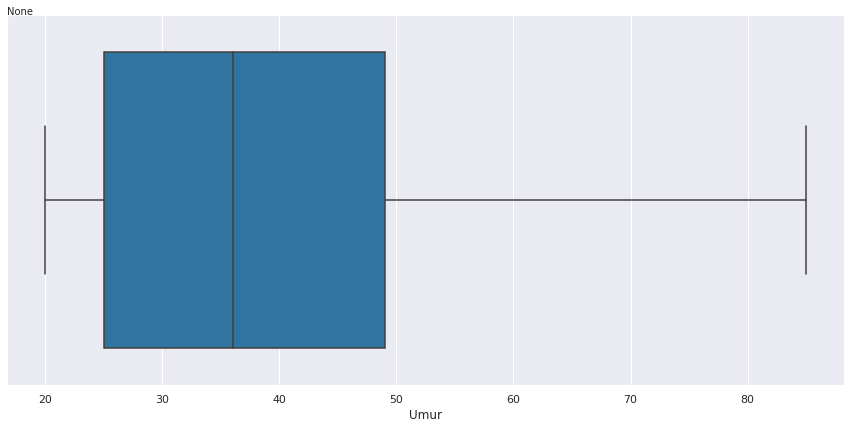

Outlier:  584


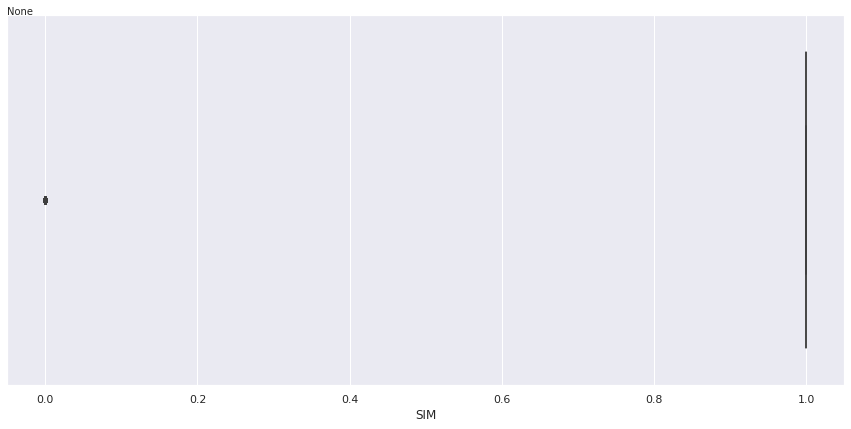

Outlier:  0


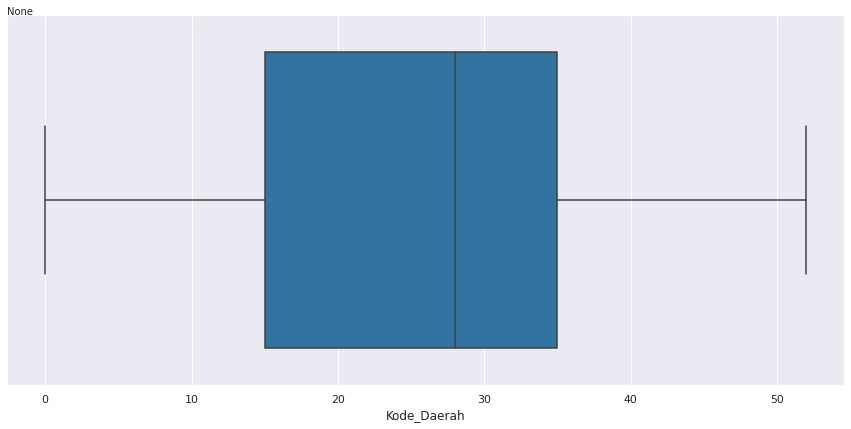

Outlier:  0


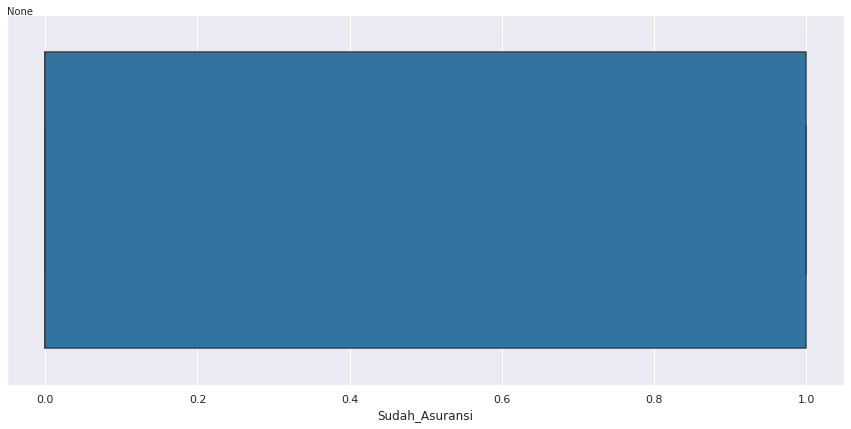

Outlier:  7328


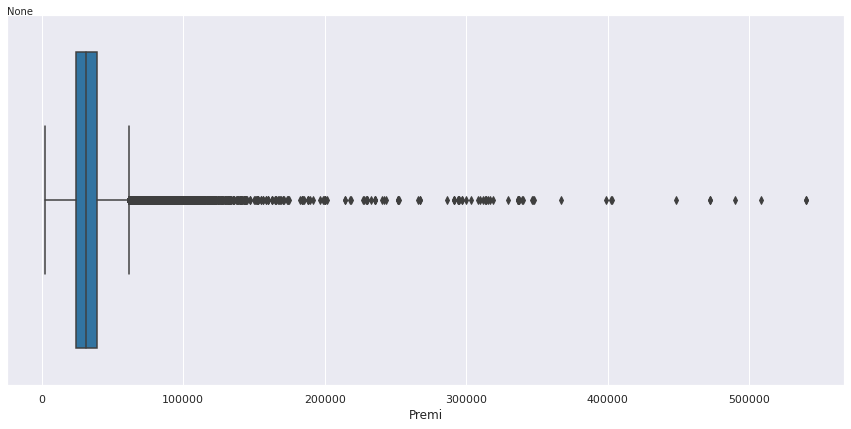

Outlier:  0


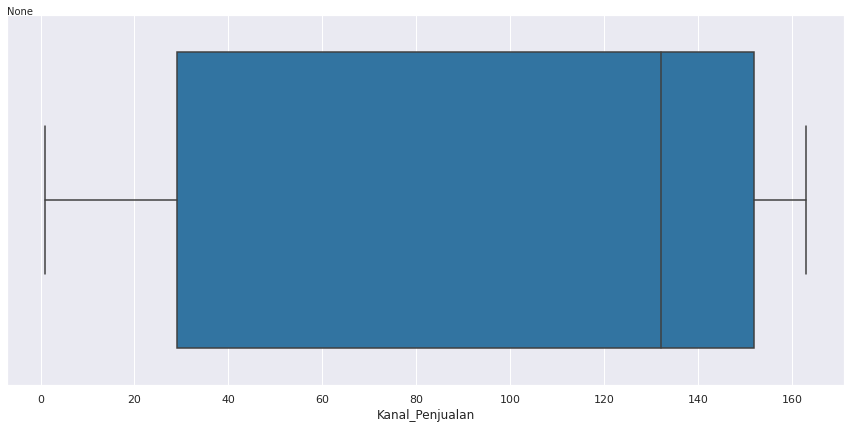

Outlier:  0


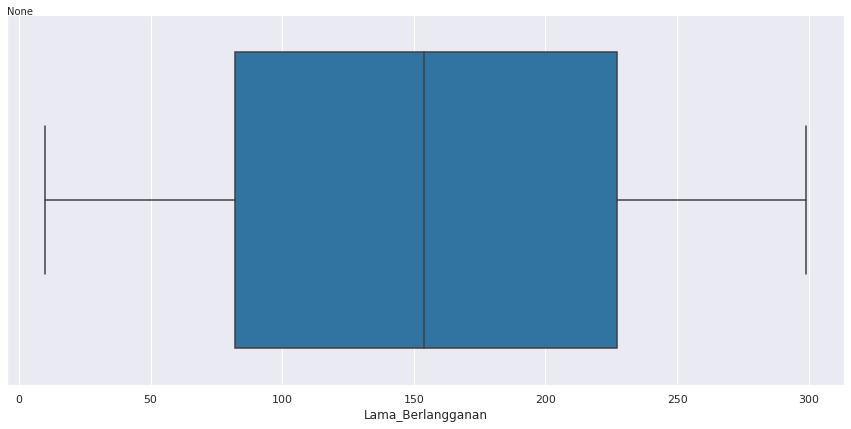

In [ ]:
for c in df.columns:
  if df[c].dtypes == 'object' or c == 'id' or c =='Tertarik':
    pass
  else:
    plt.figure(figsize=(15,15))
    ax = plt.subplot(211)
    sns.boxplot(data=df, x=c, color='tab:blue')
    plt.text(x = 0, y = 1, transform=ax.transAxes, s=f"{detect_outliers_iqr(df[c])}")
    plt.show()


In [ ]:
# code berikut untuk handling
# Saya menggunakan teknik Quantile based flooring and capping, dimana teknik ini memanfaatkan value untuk membulatkan as example
# contoh : value di atas 90 percentile, di bulatkan ke 90, value di bawah 10 percentile, dibulatkan ke 10
tenth_percentile = np.nanpercentile(df['Premi'], 10)
nine_percentil = np.nanpercentile(df['Premi'], 90)

df['Premi'] = np.where(df['Premi'] < tenth_percentile, tenth_percentile, df['Premi'])
df['Premi'] = np.where(df['Premi'] > nine_percentil, nine_percentil, df['Premi'])


Outlier:  0


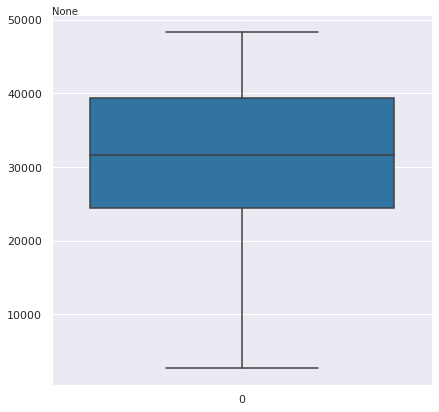

In [ ]:
# checking lagi
plt.figure(figsize=(15,15))
ax = plt.subplot(221)
sns.boxplot(data=df['Premi'], color='tab:blue')
plt.text(x = 0, y = 1, transform=ax.transAxes, s=f"{detect_outliers_iqr(df['Premi'])}")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285831 entries, 0 to 285830
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis_Kelamin      271391 non-null  object 
 1   Umur               271617 non-null  float64
 2   SIM                271427 non-null  float64
 3   Kode_Daerah        271525 non-null  float64
 4   Sudah_Asuransi     271602 non-null  float64
 5   Umur_Kendaraan     271556 non-null  object 
 6   Kendaraan_Rusak    271643 non-null  object 
 7   Premi              271262 non-null  float64
 8   Kanal_Penjualan    271532 non-null  float64
 9   Lama_Berlangganan  271839 non-null  float64
dtypes: float64(7), object(3)
memory usage: 21.8+ MB


##**Handling Missing values in data frame**
*   Handling Missing Value with Mean and Mode Methods.



In [ ]:
# handling which is the value is NaN
df['Umur'] = df['Umur'].replace(np.NaN, df['Umur'].mean())
df['Kode_Daerah'] = df['Kode_Daerah'].replace(np.NaN, df['Kode_Daerah'].mode()[0])
df['Premi'] = df['Premi'].replace(np.NaN, df['Premi'].mean())
df['Kanal_Penjualan'] = df['Kanal_Penjualan'].replace(np.NaN, df['Kanal_Penjualan'].mode()[0])
df['Lama_Berlangganan'] = df['Lama_Berlangganan'].replace(np.NaN, df['Lama_Berlangganan'].mean())
df['Jenis_Kelamin'] = df['Jenis_Kelamin'].replace(np.NaN, df['Jenis_Kelamin'].mode()[0])
df['Sudah_Asuransi'] = df['Sudah_Asuransi'].replace(np.NaN, df['Sudah_Asuransi'].mode()[0])
df['SIM'] = df['SIM'].replace(np.NaN, df['SIM'].mode()[0])
df['Umur_Kendaraan'] = df['Umur_Kendaraan'].replace(np.NaN, df['Umur_Kendaraan'].mode()[0])
df['Kendaraan_Rusak'] = df['Kendaraan_Rusak'].replace(np.NaN, df['Kendaraan_Rusak'].mode()[0])

In [ ]:
# check any value null in dataset
df.isnull().sum()

Jenis_Kelamin        0
Umur                 0
SIM                  0
Kode_Daerah          0
Sudah_Asuransi       0
Umur_Kendaraan       0
Kendaraan_Rusak      0
Premi                0
Kanal_Penjualan      0
Lama_Berlangganan    0
dtype: int64

In [ ]:
df.head(5)

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
0,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0
1,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0
2,Pria,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0
3,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0
4,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,Pernah,34857.0,88.0,194.0


In [ ]:
df['Umur_Kendaraan'].unique()

array(['< 1 Tahun', '> 2 Tahun', '1-2 Tahun'], dtype=object)

## **Scaling Data, Make Categorical Data, And Handle for Duplicated Data**

In [ ]:
# Code di bawah untuk mengecek berapa banyak duplicate data
print("Duplicate data ada sebanyak : ", df.duplicated().sum())
duplicateData = df[df.duplicated()]
duplicateData

Duplicate data ada sebanyak :  1500


,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
11067,Pria,67.0,1.0,28.0,0.0,1-2 Tahun,Pernah,48409.000000,26.0,154.286302
13036,Wanita,29.0,1.0,28.0,1.0,< 1 Tahun,Tidak,48409.000000,152.0,158.000000
13682,Wanita,23.0,1.0,8.0,1.0,< 1 Tahun,Tidak,48409.000000,152.0,154.286302
15528,Pria,41.0,1.0,28.0,0.0,1-2 Tahun,Pernah,48409.000000,124.0,117.000000
16681,Wanita,43.0,1.0,28.0,0.0,1-2 Tahun,Pernah,48409.000000,26.0,154.286302
...,...,...,...,...,...,...,...,...,...,...
285254,Wanita,43.0,1.0,28.0,0.0,1-2 Tahun,Pernah,2630.000000,124.0,252.000000
285261,Wanita,48.0,1.0,28.0,0.0,1-2 Tahun,Pernah,48409.000000,26.0,154.286302
285430,Pria,56.0,1.0,28.0,0.0,1-2 Tahun,Pernah,48409.000000,26.0,242.000000
285499,Pria,52.0,1.0,28.0,0.0,1-2 Tahun,Pernah,29395.850945,26.0,154.286302


In [ ]:
# Code di bawah untuk menghandle duplicate data, yaitu dengan cara di drop
df = df.drop_duplicates()
print("Duplicate data ada sebanyak : ", df.duplicated().sum())

Duplicate data ada sebanyak :  0


In [ ]:
# DATA LEBELING JENIS KELAMIN WANITA 1 , PRIA 0
df["Jenis_Kelamin"] = np.where(df["Jenis_Kelamin"].str.contains("Wanita"), 1, 0)

# DATA LABELING UMUR KENDARAAN
column = 'Umur_Kendaraan'
conditions = [df[column].str.contains("< 1 Tahun"), df[column].str.contains("> 2 Tahun"), df[column].str.contains("1-2 Tahun")]
choices = [ 0, 1, 2]
df['Umur_Kendaraan'] = np.select(conditions, choices, default=np.nan)

# DATA LABELING KENDARAAN RUSAK 1 = PERNAH, 0 = TIDAK
column2 = 'Kendaraan_Rusak'
conditions2 = [df[column2].str.contains("Pernah"), df[column2].str.contains("Tidak")]
choices2 = [1, 0]
df['Kendaraan_Rusak'] = np.select(conditions2, choices2, default=np.nan)

In [ ]:
df.sample(5)

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
169389,0,34.0,1.0,28.0,0.0,2.0,1.0,48409.0,122.0,146.000000
66921,1,27.0,1.0,8.0,1.0,0.0,0.0,47396.0,152.0,24.000000
204744,0,24.0,1.0,8.0,0.0,0.0,1.0,48409.0,160.0,299.000000
264388,0,20.0,1.0,8.0,1.0,0.0,0.0,44502.0,160.0,154.286302
268072,1,22.0,1.0,46.0,1.0,0.0,0.0,24384.0,152.0,294.000000


In [ ]:
# NORMALIZE IN BASE MEAN,
df=(df-df.mean())/df.std()
df.sample(5)


,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
145353,1.136064,-0.782403,0.045367,1.121391,1.137242,-1.174007,-1.060103,0.173119,0.708419,1.232915
38388,-0.880229,-1.112647,0.045367,0.116830,1.137242,-1.174007,0.943301,0.795355,0.708419,-0.321797
40494,-0.880229,0.934871,0.045367,0.116830,-0.879317,0.888010,0.943301,1.122131,-1.646127,0.020974
217929,1.136064,-0.848452,0.045367,0.116830,1.137242,0.888010,-1.060103,1.372379,0.708419,-1.276660
274091,-0.880229,-0.320060,0.045367,0.116830,-0.879317,0.888010,0.943301,0.331575,0.708419,0.167876


In [ ]:
# Export data to external excel
df.to_excel('k-means-preprocessed.xlsx', header=True, index=False )

## **Data Preparation**


In [ ]:
correlation = df.corr()
correlation

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
Jenis_Kelamin,1.000000,-0.135621,0.015969,-0.001287,0.073970,-0.148010,-0.082157,-0.002320,0.104828,0.001308
Umur,-0.135621,1.000000,-0.075347,0.040870,-0.235650,0.702808,0.247780,0.048625,-0.540762,0.000146
SIM,0.015969,-0.075347,1.000000,-0.003175,0.015298,-0.037483,-0.016493,-0.009955,0.040669,-0.001202
Kode_Daerah,-0.001287,0.040870,-0.003175,1.000000,-0.021935,0.038253,0.025686,-0.006254,-0.040236,-0.003407
Sudah_Asuransi,0.073970,-0.235650,0.015298,-0.021935,1.000000,-0.293140,-0.748706,0.013167,0.201437,0.002711
Umur_Kendaraan,-0.148010,0.702808,-0.037483,0.038253,-0.293140,1.000000,0.301968,-0.004815,-0.505110,-0.002488
Kendaraan_Rusak,-0.082157,0.247780,-0.016493,0.025686,-0.748706,0.301968,1.000000,0.000504,-0.205268,-0.001315
Premi,-0.002320,0.048625,-0.009955,-0.006254,0.013167,-0.004815,0.000504,1.000000,-0.101557,0.000059
Kanal_Penjualan,0.104828,-0.540762,0.040669,-0.040236,0.201437,-0.505110,-0.205268,-0.101557,1.000000,-0.000187
Lama_Berlangganan,0.001308,0.000146,-0.001202,-0.003407,0.002711,-0.002488,-0.001315,0.000059,-0.000187,1.000000


<Figure size 432x288 with 0 Axes>

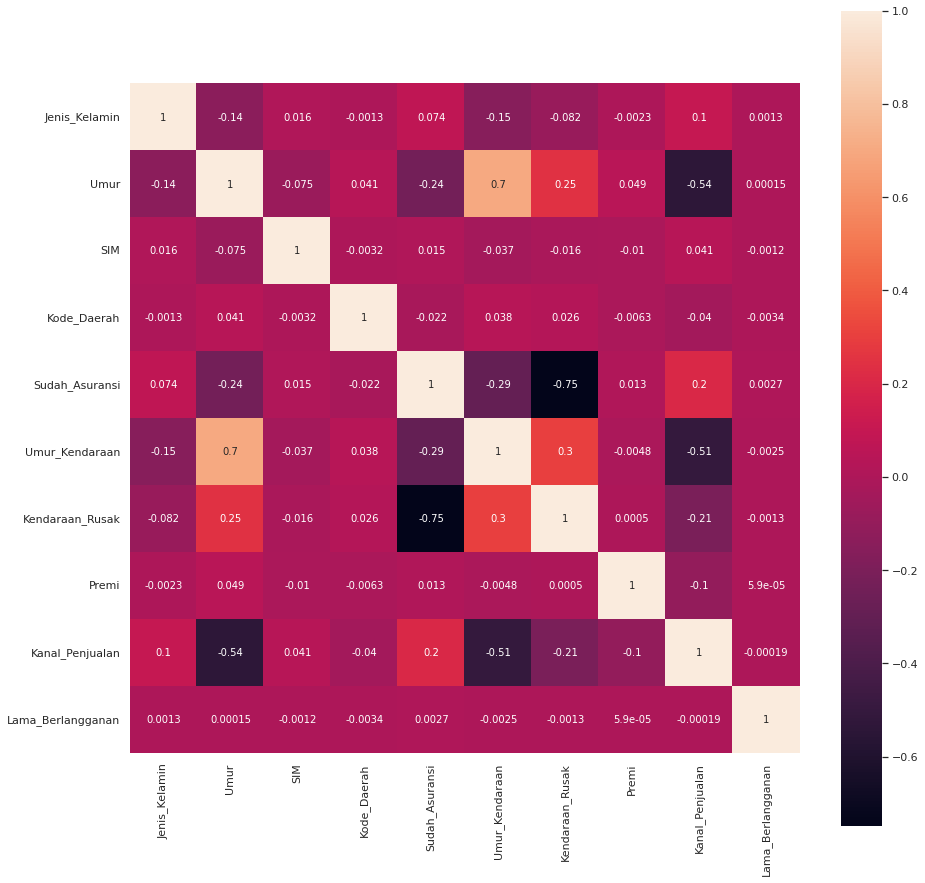

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlation, annot=True, square=True)
plt.show()

In [ ]:
# atau setelah di describe dengan heatmap, bisa dijabarkan disini dengan langsung menggunakan 'Umur' sebagai acuan karena densitynya tinggi dilihat dari heatmap
SELECTED_FEATURES_COL = ['Jenis_Kelamin', 'Umur', 'SIM', 'Kode_Daerah', 'Sudah_Asuransi', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Premi' , 'Kanal_Penjualan', 'Lama_Berlangganan']

In [ ]:
n_features = SELECTED_FEATURES_COL
kolom_umur = n_features.pop(1)
# print(kolom_umur)

In [ ]:
correlation_list={}
for index in n_features:
  dataCorrelation = df[[index,kolom_umur]]
  temp1 = dataCorrelation[index].values
  temp2 = dataCorrelation[kolom_umur].values
  key = index
  correlation_list[key] = pearsonr(temp1,temp2)[0]

In [ ]:
# Urutkan korelasi terhadap umur
data_correlation = pd.DataFrame(correlation_list, index=['Value']).T
sorted_data_correlation = data_correlation.loc[data_correlation['Value'].abs().sort_values(ascending=False).index]
sorted_data_correlation

,Value
Umur_Kendaraan,0.702808
Kanal_Penjualan,-0.540762
Kendaraan_Rusak,0.247780
Sudah_Asuransi,-0.235650
Jenis_Kelamin,-0.135621
SIM,-0.075347
Premi,0.048625
Kode_Daerah,0.040870
Lama_Berlangganan,0.000146


# **==================================================================**
# **=========WE'RE GOING TO ENTERING MAIN PROGRAM=====================**
# **==================================================================**


# K-MEANS ALGORITHM

In [ ]:
def eucli_dist(a,b):
    return np.sqrt(np.sum((a - b) ** 2))

class K_Means:
    def __init__(self, K, max_iters=100):
        # inisialisasi constructor nya
        # pada self.clusters, berisi sebuah array object kosong, contohnya adalah {0 : [] , 1:[]...dst}
        self.K = K
        self.max_iters = max_iters
        self.clusters =[[] for _ in range(self.K)]
        self.centorids = []
       
    def fit(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Number of features must be > 0")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        # Inisialisasi centroids memakai fungsi diatas
        random_centroid_samples = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[index] for index in random_centroid_samples]
        # self._initializeCentroid(self.init)
        # centroids = self.centroids
      
        # loop dibawah untuk optimisasi clusters sebanyak max_iters
        for _ in range(self.max_iters):
          # memasukkan centroid ke kumpulan clusters
          self.clusters = self._assignValue(self.centroids)
          centroids_old = self.centroids
          # mengambil centroid dari kumpulan clusters
          self.centroids = self._getCentroid(self.clusters)

          if self._isConverged(centroids_old, self.centroids):
            break
        
        return self.getClusterLabel()

    def _assignValue(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._predict(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    
    def _predict(self, sampleValue, centroids):
      # memperkirakan jarak centroid terdekat dengan euclidean distances.
        distances = [eucli_dist(sampleValue, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _getCentroid(self,clusters):
        centroids = np.zeros((self.K, self.n_features))
        for indexCluster, clusterValue in enumerate(clusters):
          clustersMean = np.mean(self.X[clusterValue], axis=0)
          centroids[indexCluster] = clustersMean
        return centroids

    def getClusterLabel(self):
        labels = np.empty(self.n_samples)

        for indexOne, cluster in enumerate(self.clusters):
          for indexTwo in cluster:
            labels[indexTwo] = indexOne
        return labels
    
    def _isConverged(self, centroidsOld , centroids):
        # Menghitung jarak dari centroids lama ke centroid baru UNTUK SEMUA centroids yang ada.
        distances = [
            eucli_dist(centroidsOld[i], centroids[i]) for i in range(self.K)
        ]

        return sum(distances) == 0

    def _distFromCenter(self):
        return np.array([min([eucli_dist(xValue, centroid) for centroid in self.centroids]) for xValue in self.X])

    def _chooseNextCenterValue(self):
        distance = self._distFromCenter()
        distance2 = distance ** 2
        probability = distance2 / distance2.sum()
        index = np.random.choice(self.X.shape[0], 1, p=probability)[0]

        return self.X[index]

    def showPlot(self, ax=None, holdon=False):
        sns.set(style="darkgrid")
        palette = sns.color_palette("hls", self.K + 1)
        data = self.X

        if ax is None:
            _, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = np.array(data[index]).T
            ax.scatter(*point, c=[palette[i], ])

        for point in self.centroids:
            ax.scatter(*point, marker="x", s=500, color="black", linewidths=10)

        if not holdon:
            plt.show()

# MAIN PROGRAM

In [ ]:
SELECTED_FEATURE = ['Umur','Kanal_Penjualan']

In [ ]:
clean_data = df[SELECTED_FEATURE]
clean_data

,Umur,Kanal_Penjualan
0,-0.584256,0.708419
1,0.604626,-1.590067
2,-1.178696,0.857914
3,1.265115,0.185186
4,0.736724,-0.487541
...,...,...
285826,-1.046598,0.708419
285827,-1.178696,0.708419
285828,-1.046598,0.708419
285829,1.925605,0.185186


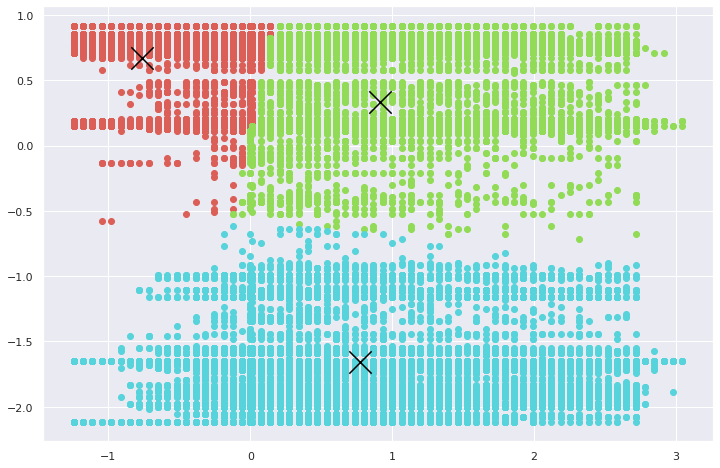

In [ ]:
kmean = K_Means(K=3, max_iters=100)
y_pred = kmean.fit(clean_data)
kmean.showPlot()

# EVALUATION


In [ ]:
from sklearn.cluster import KMeans
    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


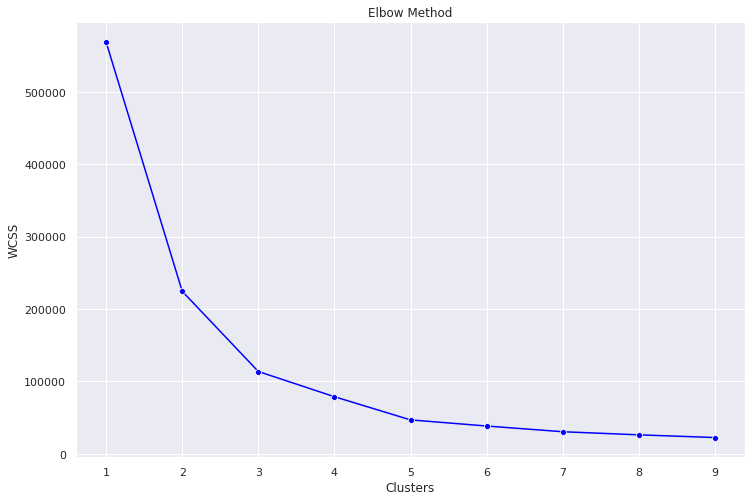

In [ ]:
WCSS = []

K = range(1,10)

for i in K:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 50)
    kmeans.fit(clean_data)
    WCSS.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
sns.lineplot(range(1,10), WCSS,marker='o',color='blue')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

# EXPERIMENT

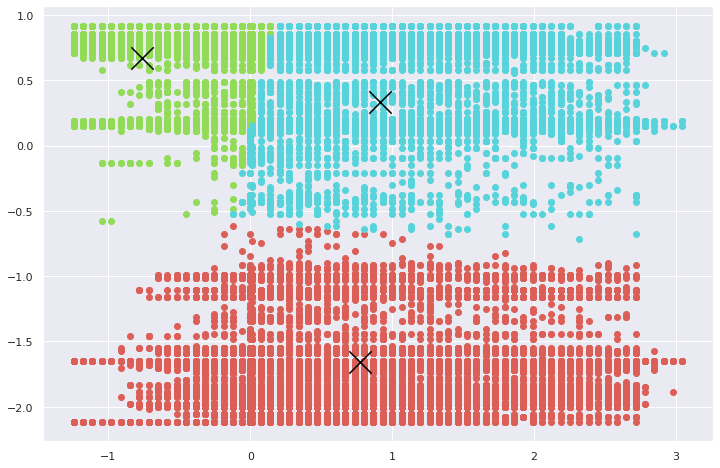

In [ ]:
kmean3 = K_Means(K=3, max_iters=100)
pred3 = kmean3.fit(clean_data)
kmean3.showPlot()

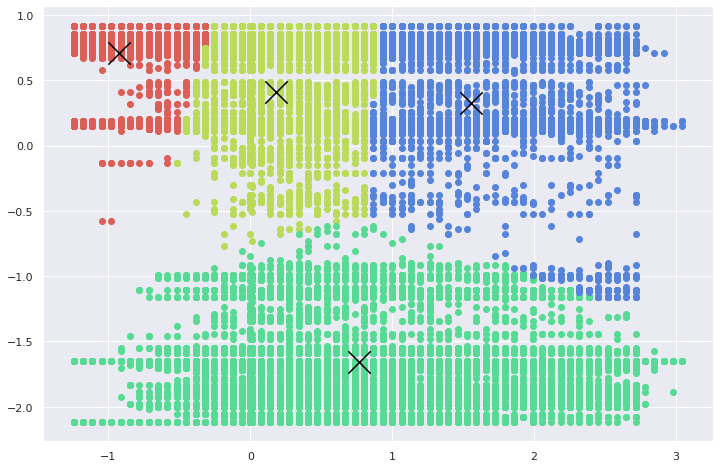

In [ ]:
kmean4 = K_Means(K=4, max_iters=100)
pred4 = kmean4.fit(clean_data)
kmean4.showPlot()